In [1]:


import torch
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import random
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

from tqdm import tqdm

In [101]:
train_path = 'dataset\images_training'
# train_path = 'C:\Machine learning\Data sets\Omniglot\images_background'
# test_path  = 'C:\Machine learning\Data sets\Omniglot\images_evaluation'
test_path  = 'dataset\images_training'

In [102]:
dirs = os.listdir(train_path)

data_count = 0

for di in dirs:
    path = os.path.join(train_path, di)
    for di2 in os.listdir(path):
        im_path = os.path.join(path, di2)
        di3 = os.listdir(im_path)
        data_count += len(di3)
        
print('Number of image data: ', data_count)

Number of image data:  19280


In [103]:
device = torch.device('cuda')

In [104]:
class OmniglotDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_to_idx = {}

        class_idx = 0
        for alphabet in os.listdir(root_dir):
            alphabet_path = os.path.join(root_dir, alphabet)
            if os.path.isdir(alphabet_path):
                for character in os.listdir(alphabet_path):
                    character_path = os.path.join(alphabet_path, character)
                    if os.path.isdir(character_path):
                        self.class_to_idx[f"{alphabet}/{character}"] = class_idx
                        for image in os.listdir(character_path):
                            if image.endswith('.png'):
                                self.data.append((os.path.join(character_path, image), class_idx))
                        class_idx += 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        same_class = idx % 2 == 0
        
        img1_idx = random.choice(range(self.__len__()))
        
        (img1, label1) = self.data[img1_idx]
        
        if same_class:
            while True:
                img2_idx = random.choice(range(self.__len__()))
                (img2, label2) = self.data[img2_idx]
                
                if label2==label1:
                    break
        else:
            while True:
                img2_idx = random.choice(range(self.__len__()))
                (img2, label2) = self.data[img2_idx]
                            
                if label2!=label1:
                    break
        
        img1 = Image.open(img1)
        img2 = Image.open(img2)
        
        img1 = img1.convert('L')
        img2 = img2.convert('L')
        
        if(self.transform != None):
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
            
        label = 1 if same_class else 0
        label = torch.from_numpy(np.array([label], dtype = np.float32))
        
        return img1.to(device), img2.to(device), label.to(device)

In [105]:
class OmniglotTestDataset(Dataset):
    def __init__(self, root_dir, transform=None, times=200, way=20):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_to_idx = {}
        self.times = times
        self.way = way

        class_idx = 0
        for alphabet in os.listdir(root_dir):
            alphabet_path = os.path.join(root_dir, alphabet)
            if os.path.isdir(alphabet_path):
                for character in os.listdir(alphabet_path):
                    character_path = os.path.join(alphabet_path, character)
                    if os.path.isdir(character_path):
                        self.class_to_idx[f"{alphabet}/{character}"] = class_idx
                        for image in os.listdir(character_path):
                            if image.endswith('.png'):
                                self.data.append((os.path.join(character_path, image), class_idx))
                        class_idx += 1

    def __len__(self):
        return self.times * self.way

    def __getitem__(self, index):
        idx = index % self.way
        label = None
        
        if idx == 0:
            self.img1 = random.choice(self.data)
            while True:
                img2 = random.choice(self.data)
                if self.img1[1] == img2[1]:
                    break
                
        else:
            while True:
                img2 = random.choice(self.data)
                if self.img1[1] != img2[1]:
                    break

        img1 = Image.open(self.img1[0])
        img2 = Image.open(img2[0])
        img1 = img1.convert('L')
        img2 = img2.convert('L')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        return img1.to(device), img2.to(device)

In [106]:
train_transform = transforms.Compose([
    transforms.RandomAffine(15),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

In [107]:

class OmniglotModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        # input = 1, 105, 105
        features = 4096
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 10),    # 64 96 96
            nn.ReLU(),
            nn.MaxPool2d(2),         # 64 48 48
            
            nn.Conv2d(64, 128, 7),   # 128 42 42
            nn.ReLU(),
            nn.MaxPool2d(2),         # 128 21 21
            
            nn.Conv2d(128, 128, 4),  # 128 18 18
            nn.ReLU(),
            nn.MaxPool2d(2),         # 128 9 9
            
            nn.Conv2d(128, 256, 4),  # 256 6 6
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*6*6, features),
            nn.Sigmoid()
        )
        
        self.output = nn.Sequential(
            nn.Linear(features, 1),
            nn.Sigmoid()
        )
        
        
    def forward_x(self, x):
        x = self.conv(x)
        x = self.fc(x)
        
        return x
        
    def forward(self, x1, x2):
        x1 = self.forward_x(x1)    
        x2 = self.forward_x(x2)    
        
        l1 = torch.abs(x1- x2)
        
        out = self.output(l1)
        
        return out

In [108]:
train_dataset = OmniglotDataset(train_path, transform=train_transform)

test_dataset = OmniglotTestDataset(test_path, transform=test_transform)

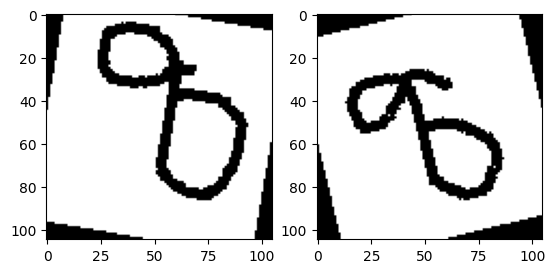

In [113]:
im1, im2, label = train_dataset.__getitem__(0)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(im1.cpu().squeeze(), cmap='gray')
ax[1].imshow(im2.cpu().squeeze(), cmap='gray')

In [114]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

In [115]:
model = OmniglotModel()
model = model.to(device)

# ------------------------------

model.load_state_dict(torch.load('OmniglotModel.pth'))

# ------------------------------

ud = []
lossi = []

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23448\853799656.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('OmniglotModel.pth'))


In [14]:
def accuracy():
    model.eval()
    with torch.no_grad():
        count = 0.0
        total = 0.0
        for idx, (im1, im2) in tqdm(enumerate(test_loader), total=len(test_loader)):
            
            output = model(im1, im2)
            
            output = output.view(-1)
            
            pred = F.softmax(output)
            
            if(torch.argmax(pred).item() == 0):
                count += 1.0
            
            total +=1.0
    return count / total

In [13]:
loss_fn = nn.BCELoss(reduction='mean')

In [250]:
lr = 6e-4
optim = AdamW(model.parameters(), lr=lr)
scheduler = StepLR(optim, step_size=500, gamma = 0.9)

In [253]:
epochs = 100

for ep in range(epochs):
    model.train()
    
    batch_loss = 0.0
    
    for image1, image2, labels in tqdm(train_dataloader, total = len(train_dataloader)):

    
        logits = model(image1, image2)
        
        optim.zero_grad()
        loss = loss_fn(logits, labels)
        
        loss.backward()
        optim.step()
        scheduler.step()
        
        with torch.no_grad():
            lossi.append(loss.log10().item())
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters()])

            batch_loss += loss.item()
            
            
    print('Epoch loss: ', batch_loss/batch_size, 'Learning rate: ', scheduler.get_last_lr()[-1])    

  0%|          | 0/151 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_26916\2219253084.py:22: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1808.)
  ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters()])
100%|██████████| 151/151 [01:01<00:00,  2.46it/s]


Epoch loss:  0.057654958007333335 Learning rate:  0.0002324522934


100%|██████████| 151/151 [00:59<00:00,  2.54it/s]


Epoch loss:  0.05911692775407573 Learning rate:  0.0002324522934


100%|██████████| 151/151 [00:59<00:00,  2.54it/s]


Epoch loss:  0.05787256624898873 Learning rate:  0.00020920706406


100%|██████████| 151/151 [00:58<00:00,  2.57it/s]


Epoch loss:  0.050012127074296586 Learning rate:  0.00020920706406


100%|██████████| 151/151 [00:58<00:00,  2.56it/s]


Epoch loss:  0.05260460722638527 Learning rate:  0.00020920706406


100%|██████████| 151/151 [00:58<00:00,  2.57it/s]


Epoch loss:  0.056407712363579776 Learning rate:  0.000188286357654


100%|██████████| 151/151 [00:59<00:00,  2.52it/s]


Epoch loss:  0.04543088102218462 Learning rate:  0.000188286357654


100%|██████████| 151/151 [00:59<00:00,  2.55it/s]


Epoch loss:  0.04908774312934838 Learning rate:  0.000188286357654


100%|██████████| 151/151 [00:59<00:00,  2.55it/s]


Epoch loss:  0.04574202746516676 Learning rate:  0.0001694577218886


100%|██████████| 151/151 [00:59<00:00,  2.55it/s]


Epoch loss:  0.044348173185426276 Learning rate:  0.0001694577218886


100%|██████████| 151/151 [00:59<00:00,  2.55it/s]


Epoch loss:  0.0414785657885659 Learning rate:  0.0001694577218886


100%|██████████| 151/151 [00:59<00:00,  2.53it/s]


Epoch loss:  0.0412239393008349 Learning rate:  0.00015251194969974


100%|██████████| 151/151 [00:58<00:00,  2.57it/s]


Epoch loss:  0.04480331047670916 Learning rate:  0.00015251194969974


100%|██████████| 151/151 [00:59<00:00,  2.56it/s]


Epoch loss:  0.04113865672843531 Learning rate:  0.00015251194969974


100%|██████████| 151/151 [00:59<00:00,  2.55it/s]


Epoch loss:  0.03659777219945681 Learning rate:  0.00015251194969974


100%|██████████| 151/151 [00:59<00:00,  2.54it/s]


Epoch loss:  0.03599275272426894 Learning rate:  0.000137260754729766


100%|██████████| 151/151 [00:58<00:00,  2.57it/s]


Epoch loss:  0.04121469187157345 Learning rate:  0.000137260754729766


100%|██████████| 151/151 [00:59<00:00,  2.56it/s]


Epoch loss:  0.03652557046007132 Learning rate:  0.000137260754729766


100%|██████████| 151/151 [00:58<00:00,  2.57it/s]


Epoch loss:  0.043000640856917016 Learning rate:  0.00012353467925678942


100%|██████████| 151/151 [00:59<00:00,  2.56it/s]


Epoch loss:  0.03883059768486419 Learning rate:  0.00012353467925678942


100%|██████████| 151/151 [00:58<00:00,  2.57it/s]


Epoch loss:  0.03428699670257629 Learning rate:  0.00012353467925678942


100%|██████████| 151/151 [00:58<00:00,  2.58it/s]


Epoch loss:  0.03642339734506095 Learning rate:  0.00011118121133111048


100%|██████████| 151/151 [00:58<00:00,  2.58it/s]


Epoch loss:  0.034312454947212245 Learning rate:  0.00011118121133111048


100%|██████████| 151/151 [01:00<00:00,  2.48it/s]


Epoch loss:  0.0368869747435383 Learning rate:  0.00011118121133111048


100%|██████████| 151/151 [00:56<00:00,  2.68it/s]


Epoch loss:  0.035070872410869924 Learning rate:  0.00011118121133111048


100%|██████████| 151/151 [01:00<00:00,  2.49it/s]


Epoch loss:  0.03416026096238056 Learning rate:  0.00010006309019799944


100%|██████████| 151/151 [00:59<00:00,  2.54it/s]


Epoch loss:  0.03477719990769401 Learning rate:  0.00010006309019799944


100%|██████████| 151/151 [00:58<00:00,  2.56it/s]


Epoch loss:  0.032615004129183944 Learning rate:  0.00010006309019799944


100%|██████████| 151/151 [00:59<00:00,  2.56it/s]


Epoch loss:  0.0331187985248107 Learning rate:  9.00567811781995e-05


100%|██████████| 151/151 [00:58<00:00,  2.56it/s]


Epoch loss:  0.030013917523319833 Learning rate:  9.00567811781995e-05


100%|██████████| 151/151 [00:58<00:00,  2.56it/s]


Epoch loss:  0.033994385295955 Learning rate:  9.00567811781995e-05


100%|██████████| 151/151 [00:58<00:00,  2.60it/s]


Epoch loss:  0.034151357005612226 Learning rate:  8.105110306037955e-05


100%|██████████| 151/151 [00:58<00:00,  2.59it/s]


Epoch loss:  0.03017532092781039 Learning rate:  8.105110306037955e-05


100%|██████████| 151/151 [00:58<00:00,  2.59it/s]


Epoch loss:  0.029856990920961834 Learning rate:  8.105110306037955e-05


100%|██████████| 151/151 [00:58<00:00,  2.59it/s]


Epoch loss:  0.031099153304239735 Learning rate:  8.105110306037955e-05


100%|██████████| 151/151 [00:59<00:00,  2.55it/s]


Epoch loss:  0.031490082346863346 Learning rate:  7.29459927543416e-05


100%|██████████| 151/151 [01:01<00:00,  2.45it/s]


Epoch loss:  0.029920273065727088 Learning rate:  7.29459927543416e-05


100%|██████████| 151/151 [01:02<00:00,  2.44it/s]


Epoch loss:  0.030454044135694858 Learning rate:  7.29459927543416e-05


100%|██████████| 151/151 [00:59<00:00,  2.53it/s]


Epoch loss:  0.027348981886461843 Learning rate:  6.565139347890744e-05


100%|██████████| 151/151 [00:59<00:00,  2.54it/s]


Epoch loss:  0.02873909666595864 Learning rate:  6.565139347890744e-05


100%|██████████| 151/151 [01:02<00:00,  2.42it/s]


Epoch loss:  0.025953423260943964 Learning rate:  6.565139347890744e-05


100%|██████████| 151/151 [01:02<00:00,  2.42it/s]


Epoch loss:  0.028224746441992465 Learning rate:  5.9086254131016696e-05


100%|██████████| 151/151 [01:01<00:00,  2.46it/s]


Epoch loss:  0.027185512844880577 Learning rate:  5.9086254131016696e-05


100%|██████████| 151/151 [00:59<00:00,  2.53it/s]


Epoch loss:  0.03268498667966924 Learning rate:  5.9086254131016696e-05


100%|██████████| 151/151 [01:00<00:00,  2.49it/s]


Epoch loss:  0.032303681487974245 Learning rate:  5.9086254131016696e-05


100%|██████████| 151/151 [00:59<00:00,  2.55it/s]


Epoch loss:  0.029343270656681852 Learning rate:  5.3177628717915026e-05


100%|██████████| 151/151 [00:59<00:00,  2.54it/s]


Epoch loss:  0.025016838197188918 Learning rate:  5.3177628717915026e-05


100%|██████████| 151/151 [00:59<00:00,  2.53it/s]


Epoch loss:  0.025967599633077043 Learning rate:  5.3177628717915026e-05


100%|██████████| 151/151 [01:00<00:00,  2.51it/s]


Epoch loss:  0.025249483673178474 Learning rate:  4.785986584612352e-05


100%|██████████| 151/151 [00:59<00:00,  2.53it/s]


Epoch loss:  0.025061033840756863 Learning rate:  4.785986584612352e-05


100%|██████████| 151/151 [00:59<00:00,  2.52it/s]


Epoch loss:  0.02595136877062032 Learning rate:  4.785986584612352e-05


100%|██████████| 151/151 [00:58<00:00,  2.60it/s]


Epoch loss:  0.023976807162398472 Learning rate:  4.3073879261511174e-05


100%|██████████| 151/151 [00:59<00:00,  2.56it/s]


Epoch loss:  0.025103695974394213 Learning rate:  4.3073879261511174e-05


100%|██████████| 151/151 [01:00<00:00,  2.51it/s]


Epoch loss:  0.024669817355970736 Learning rate:  4.3073879261511174e-05


100%|██████████| 151/151 [00:59<00:00,  2.55it/s]


Epoch loss:  0.026719101048001903 Learning rate:  4.3073879261511174e-05


100%|██████████| 151/151 [01:00<00:00,  2.51it/s]


Epoch loss:  0.024737604539041058 Learning rate:  3.876649133536006e-05


100%|██████████| 151/151 [01:00<00:00,  2.51it/s]


Epoch loss:  0.02225067189829133 Learning rate:  3.876649133536006e-05


100%|██████████| 151/151 [00:59<00:00,  2.53it/s]


Epoch loss:  0.02514068765231059 Learning rate:  3.876649133536006e-05


100%|██████████| 151/151 [00:59<00:00,  2.56it/s]


Epoch loss:  0.024236250126705272 Learning rate:  3.488984220182405e-05


100%|██████████| 151/151 [00:59<00:00,  2.52it/s]


Epoch loss:  0.02631648521310126 Learning rate:  3.488984220182405e-05


100%|██████████| 151/151 [00:59<00:00,  2.54it/s]


Epoch loss:  0.02385834168853762 Learning rate:  3.488984220182405e-05


100%|██████████| 151/151 [00:59<00:00,  2.55it/s]


Epoch loss:  0.028179842984172865 Learning rate:  3.140085798164165e-05


100%|██████████| 151/151 [00:59<00:00,  2.56it/s]


Epoch loss:  0.02393677885629586 Learning rate:  3.140085798164165e-05


100%|██████████| 151/151 [00:59<00:00,  2.54it/s]


Epoch loss:  0.025389165113665513 Learning rate:  3.140085798164165e-05


100%|██████████| 151/151 [01:01<00:00,  2.46it/s]


Epoch loss:  0.021660077811247902 Learning rate:  2.8260772183477486e-05


100%|██████████| 151/151 [00:59<00:00,  2.52it/s]


Epoch loss:  0.02137639249122003 Learning rate:  2.8260772183477486e-05


100%|██████████| 151/151 [00:59<00:00,  2.53it/s]


Epoch loss:  0.022361374358297326 Learning rate:  2.8260772183477486e-05


100%|██████████| 151/151 [01:01<00:00,  2.44it/s]


Epoch loss:  0.024897223396692425 Learning rate:  2.8260772183477486e-05


  1%|▏         | 2/151 [00:01<01:32,  1.61it/s]


KeyboardInterrupt: 

In [289]:
# torch.save(model.state_dict(), 'OmniglotModel.pth')

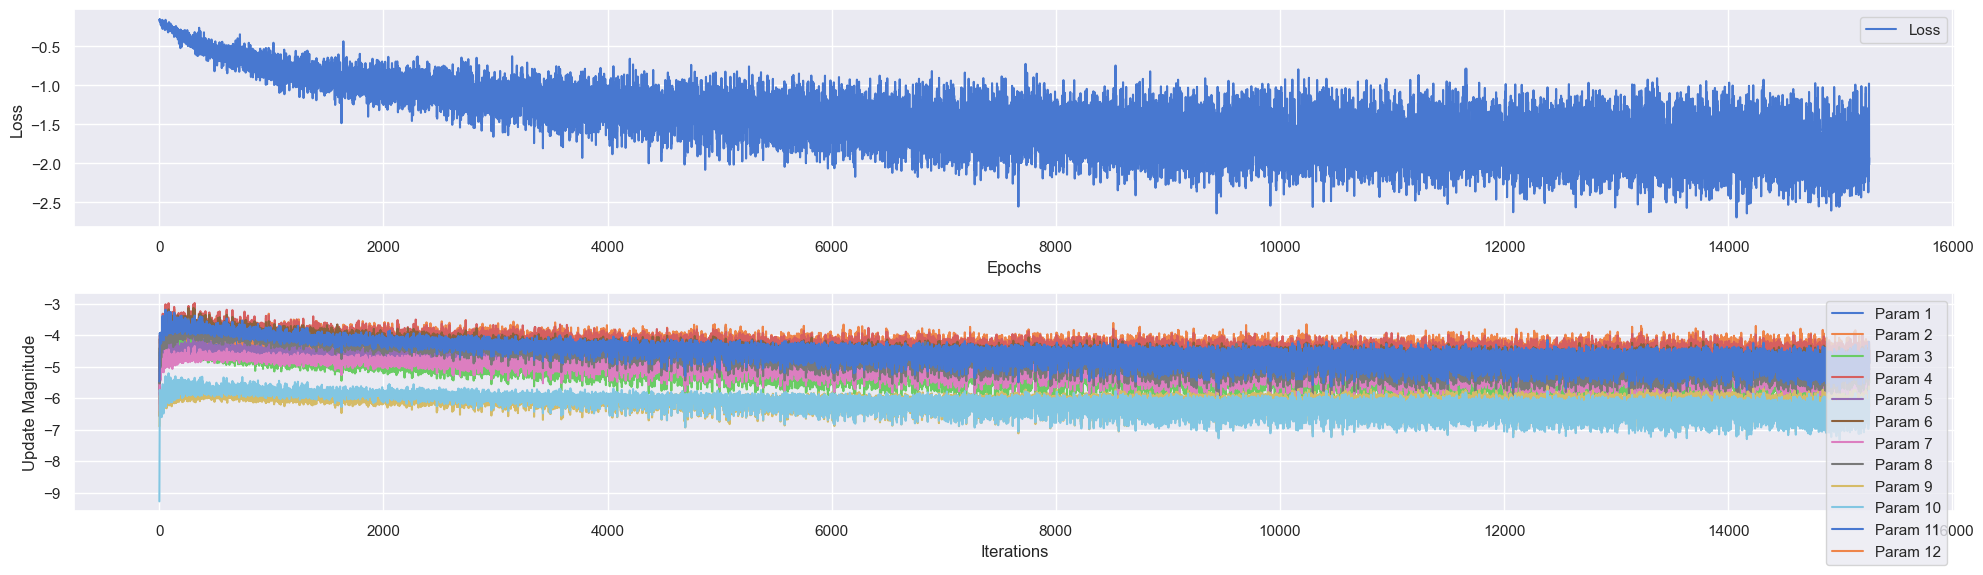

In [293]:
sns.set_theme(style="darkgrid")
sns.set_palette("muted")

fig, ax = plt.subplots(2, 1, figsize=(20, 6)) 

sns.lineplot(x=range(len(lossi)), y=lossi, ax=ax[0], label='Loss')  
ax[0].set_xlabel('Epochs')  
ax[0].set_ylabel('Loss')    
ax[0].legend()              

for i, param_updates in enumerate(zip(*ud)):  
    sns.lineplot(x=range(len(param_updates)), y=param_updates, ax=ax[1], label=f'Param {i+1}')
ax[1].set_xlabel('Iterations')  
ax[1].set_ylabel('Update Magnitude')  
ax[1].legend()  

plt.tight_layout()
plt.show()

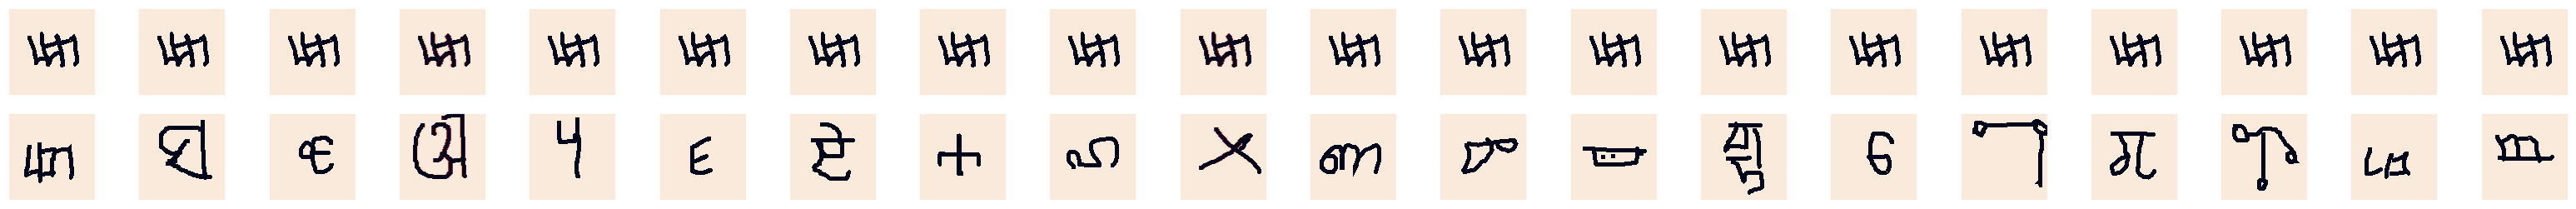

In [285]:
im1, im2 = next(iter(test_loader))

im1 = im1.cpu().numpy()
im2 = im2.cpu().numpy()

plt.figure(figsize=(40, 3))
for i in range(40):
    idx = i % 20
    ax = plt.subplot(2, 20, i+1)
    if i<20:
        ax.imshow(im1[idx].squeeze())
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.imshow(im2[idx].squeeze())
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])

In [116]:
test_dataset = OmniglotTestDataset(test_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

model.eval()

with torch.no_grad():
    count = 0.0
    total = 0.0
    for idx, (im1, im2) in tqdm(enumerate(test_loader), total=len(test_loader)):
        output = model(im1, im2)
        
        output = output.view(-1)
        
        pred = F.softmax(output, dim=0)
        
        if(torch.argmax(pred).item() == 0):
            count += 1.0
        
        total +=1.0
        
    print('Test accuracy :', count / total)

100%|██████████| 200/200 [00:50<00:00,  3.97it/s]

Test accuracy : 0.98


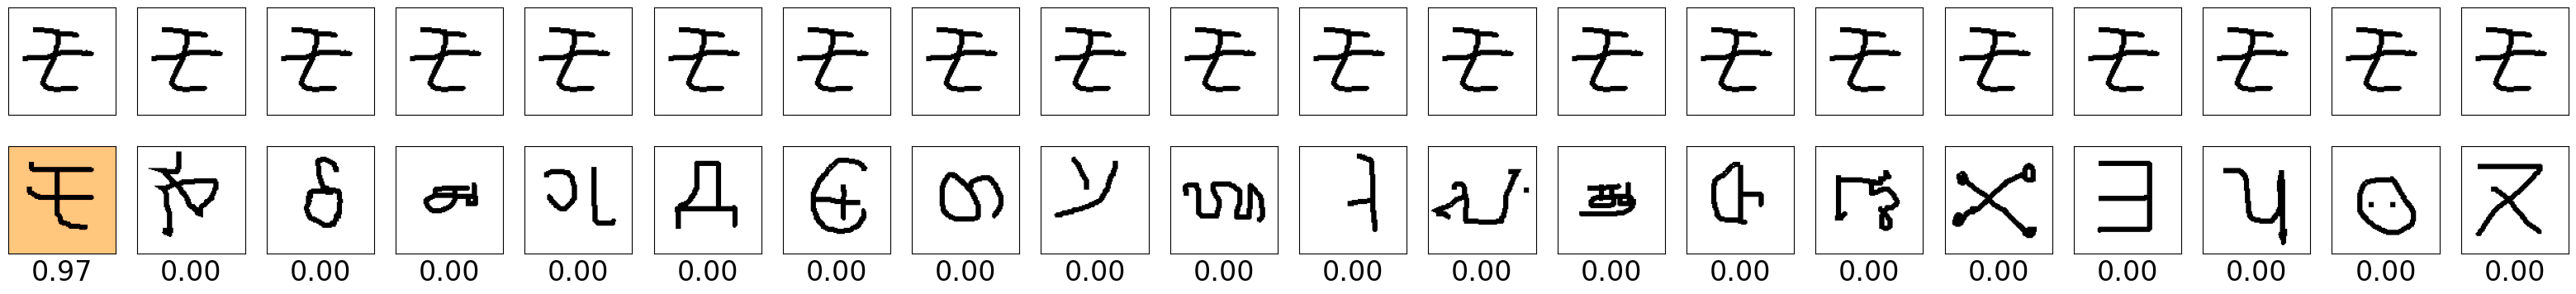

In [119]:
def classify_single_image(n_way=20):
    test_dataset = OmniglotTestDataset(test_path, transform=test_transform, way=n_way)
    test_loader = DataLoader(test_dataset, batch_size=n_way, shuffle=False)

    m1, m2 = next(iter(test_loader))

    model.eval()

    pred = model(m1, m2)
    pred = pred.cpu().detach().numpy().flatten()
    
    im1 = m1.cpu().numpy()
    im2 = m2.cpu().numpy()

    plt.figure(figsize=(40, 4))
    for i in range(n_way * 2):
        idx = i % n_way
        ax = plt.subplot(2, n_way, i+1)
        if i<n_way:
            ax.imshow(im1[idx].squeeze(), cmap='gray')
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            max_index = np.argmax(pred)
            
            ax.imshow(im2[idx].squeeze(), cmap='gray' if idx != max_index else 'copper')
            ax.set_xlabel(f'{pred[idx]:.2f}', fontsize=24)
            ax.set_ylabel('')
            ax.set_xticks([])
            ax.set_yticks([])
            
classify_single_image()